# The credit fraud dataset - Synthesizing the minority class
In this notebook it's presented a practical exercise of how to use the avilable library GANs to synthesize tabular data.
For the purpose of this exercise it has been used the Credit Fraud dataset from Kaggle, that you can find here:https: //www.kaggle.com/mlg-ulb/creditcardfraud

In [28]:
import importlib

import pandas as pd
import numpy as np
import sklearn.cluster as cluster
import matplotlib.pyplot as plt

from models.gan import model
importlib.reload(model)

from models.gan.model import GAN
from preprocessing.credit_fraud import *

model = GAN

In [29]:
#Read the data
data = pd.read_csv('data/data_processed.csv', index_col=[0])
data_cols = list(data.columns[ data.columns != 'Class' ])
label_cols = ['Class']

print('Dataset columns: {}'.format(data_cols))
sorted_cols = ['V14', 'V4', 'V10', 'V17', 'Time', 'V12', 'V26', 'Amount', 'V21', 'V8', 'V11', 'V7', 'V28', 'V19', 'V3', 'V22', 'V6', 'V20', 'V27', 'V16', 'V13', 'V25', 'V24', 'V18', 'V2', 'V1', 'V5', 'V15', 'V9', 'V23', 'Class']
data = data[ sorted_cols ].copy()

Dataset columns: ['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount']


In [30]:
#Before training the GAN do not forget to apply the required data transformations
#To ease here we've applied a PowerTransformation
data = transformations(data)

#For the purpose of this example we will only synthesize the minority class
train_data = data.loc[ data['Class']==1 ].copy()

print("Dataset info: Number of records - {} Number of varibles - {}".format(train_data.shape[0], train_data.shape[1]))

algorithm = cluster.KMeans
args, kwds = (), {'n_clusters':2, 'random_state':0}
labels = algorithm(*args, **kwds).fit_predict(train_data[ data_cols ])

print( pd.DataFrame( [ [np.sum(labels==i)] for i in np.unique(labels) ], columns=['count'], index=np.unique(labels) ) )

fraud_w_classes = train_data.copy()
fraud_w_classes['Class'] = labels

Dataset info: Number of records - 492 Number of varibles - 31
   count
0    384
1    108


# GAN training

Below you can try to train your own generators using the available GANs architectures. You can train it either with labels (created using KMeans) or with no labels at all. 

Remeber that for this exercise in particular we've decided to synthesize only the minority class from the Credit Fraud dataset.

In [31]:
#Define the GAN and training parameters
noise_dim = 32
dim = 128
batch_size = 128

log_step = 100
epochs = 5000+1
learning_rate = 5e-4
models_dir = './cache'

train_sample = fraud_w_classes.copy().reset_index(drop=True)
train_sample = pd.get_dummies(train_sample, columns=['Class'], prefix='Class', drop_first=True)
label_cols = [ i for i in train_sample.columns if 'Class' in i ]
data_cols = [ i for i in train_sample.columns if i not in label_cols ]
train_sample[ data_cols ] = train_sample[ data_cols ] / 10 # scale to random noise size, one less thing to learn
train_no_label = train_sample[ data_cols ]

gan_args = [batch_size, learning_rate, noise_dim, train_sample.shape[1], dim]
train_args = ['', epochs, log_step]

In [33]:
#Training the GAN model chosen: Vanilla GAN, CGAN, DCGAN, etc.
synthesizer = model(gan_args)
synthesizer.train(train_sample, train_args)

0 [D loss: 0.705997, acc.: 45.31%] [G loss: 0.663525]
generated_data
1 [D loss: 0.678726, acc.: 50.00%] [G loss: 0.669143]
2 [D loss: 0.665418, acc.: 50.00%] [G loss: 0.662125]
3 [D loss: 0.676714, acc.: 50.00%] [G loss: 0.635445]
4 [D loss: 0.734472, acc.: 50.00%] [G loss: 0.589705]
5 [D loss: 0.780536, acc.: 50.00%] [G loss: 0.580895]
6 [D loss: 0.795835, acc.: 48.83%] [G loss: 0.629809]
7 [D loss: 0.762679, acc.: 45.70%] [G loss: 0.754075]
8 [D loss: 0.722075, acc.: 29.69%] [G loss: 0.903090]
9 [D loss: 0.667899, acc.: 61.33%] [G loss: 1.034845]
10 [D loss: 0.637842, acc.: 60.55%] [G loss: 1.157126]
11 [D loss: 0.627896, acc.: 60.94%] [G loss: 1.148153]
12 [D loss: 0.633042, acc.: 60.94%] [G loss: 1.105542]
13 [D loss: 0.650867, acc.: 65.23%] [G loss: 0.971893]
14 [D loss: 0.657101, acc.: 76.56%] [G loss: 0.868371]
15 [D loss: 0.648712, acc.: 89.45%] [G loss: 0.823496]
16 [D loss: 0.635049, acc.: 90.62%] [G loss: 0.799988]
17 [D loss: 0.630502, acc.: 73.83%] [G loss: 0.755666]
18 [D

142 [D loss: 0.674553, acc.: 55.47%] [G loss: 0.827785]
143 [D loss: 0.705194, acc.: 45.31%] [G loss: 0.776109]
144 [D loss: 0.730318, acc.: 37.89%] [G loss: 0.763589]
145 [D loss: 0.737484, acc.: 36.72%] [G loss: 0.797294]
146 [D loss: 0.710896, acc.: 46.88%] [G loss: 0.839641]
147 [D loss: 0.669995, acc.: 64.45%] [G loss: 0.932175]
148 [D loss: 0.624906, acc.: 67.97%] [G loss: 1.064448]
149 [D loss: 0.590154, acc.: 69.92%] [G loss: 1.129902]
150 [D loss: 0.583595, acc.: 73.44%] [G loss: 1.023695]
151 [D loss: 0.588880, acc.: 75.00%] [G loss: 0.969657]
152 [D loss: 0.602711, acc.: 73.44%] [G loss: 0.938855]
153 [D loss: 0.603706, acc.: 73.83%] [G loss: 0.903461]
154 [D loss: 0.636310, acc.: 62.50%] [G loss: 0.808761]
155 [D loss: 0.665782, acc.: 49.22%] [G loss: 0.767276]
156 [D loss: 0.693030, acc.: 38.28%] [G loss: 0.722557]
157 [D loss: 0.695195, acc.: 35.94%] [G loss: 0.713708]
158 [D loss: 0.697298, acc.: 38.28%] [G loss: 0.721151]
159 [D loss: 0.703566, acc.: 40.23%] [G loss: 0.

285 [D loss: 0.693662, acc.: 37.11%] [G loss: 0.804863]
286 [D loss: 0.667689, acc.: 54.69%] [G loss: 0.885857]
287 [D loss: 0.642965, acc.: 60.55%] [G loss: 0.981873]
288 [D loss: 0.617147, acc.: 60.94%] [G loss: 1.042374]
289 [D loss: 0.619943, acc.: 61.33%] [G loss: 1.039297]
290 [D loss: 0.625420, acc.: 62.89%] [G loss: 0.962278]
291 [D loss: 0.642015, acc.: 66.80%] [G loss: 0.897271]
292 [D loss: 0.649908, acc.: 65.62%] [G loss: 0.820338]
293 [D loss: 0.655330, acc.: 66.41%] [G loss: 0.797043]
294 [D loss: 0.647047, acc.: 67.58%] [G loss: 0.764338]
295 [D loss: 0.649811, acc.: 66.80%] [G loss: 0.765815]
296 [D loss: 0.646034, acc.: 64.84%] [G loss: 0.768596]
297 [D loss: 0.643233, acc.: 63.67%] [G loss: 0.754955]
298 [D loss: 0.647069, acc.: 63.67%] [G loss: 0.771468]
299 [D loss: 0.636342, acc.: 64.45%] [G loss: 0.778726]
300 [D loss: 0.637147, acc.: 64.84%] [G loss: 0.780960]
generated_data
301 [D loss: 0.629892, acc.: 65.23%] [G loss: 0.799522]
302 [D loss: 0.624341, acc.: 66.8

429 [D loss: 0.596991, acc.: 67.58%] [G loss: 1.020143]
430 [D loss: 0.609405, acc.: 64.84%] [G loss: 1.005740]
431 [D loss: 0.622950, acc.: 63.67%] [G loss: 0.940245]
432 [D loss: 0.624112, acc.: 61.72%] [G loss: 0.875756]
433 [D loss: 0.639999, acc.: 61.33%] [G loss: 0.822337]
434 [D loss: 0.642473, acc.: 58.98%] [G loss: 0.831458]
435 [D loss: 0.645025, acc.: 57.42%] [G loss: 0.856150]
436 [D loss: 0.624581, acc.: 62.11%] [G loss: 0.881781]
437 [D loss: 0.604433, acc.: 65.23%] [G loss: 0.903968]
438 [D loss: 0.616213, acc.: 59.77%] [G loss: 0.908546]
439 [D loss: 0.606887, acc.: 65.23%] [G loss: 0.924371]
440 [D loss: 0.597285, acc.: 66.80%] [G loss: 0.881923]
441 [D loss: 0.625471, acc.: 63.28%] [G loss: 0.891334]
442 [D loss: 0.608584, acc.: 68.36%] [G loss: 0.870383]
443 [D loss: 0.608285, acc.: 66.41%] [G loss: 0.841694]
444 [D loss: 0.606771, acc.: 67.19%] [G loss: 0.838457]
445 [D loss: 0.600563, acc.: 66.80%] [G loss: 0.831316]
446 [D loss: 0.607603, acc.: 66.02%] [G loss: 0.

572 [D loss: 0.634152, acc.: 65.23%] [G loss: 0.929437]
573 [D loss: 0.653172, acc.: 64.45%] [G loss: 0.853222]
574 [D loss: 0.660609, acc.: 60.16%] [G loss: 0.881559]
575 [D loss: 0.647633, acc.: 62.89%] [G loss: 0.881723]
576 [D loss: 0.638087, acc.: 64.45%] [G loss: 0.926188]
577 [D loss: 0.631797, acc.: 64.45%] [G loss: 0.960888]
578 [D loss: 0.609306, acc.: 64.84%] [G loss: 0.939230]
579 [D loss: 0.598581, acc.: 66.41%] [G loss: 0.950608]
580 [D loss: 0.605273, acc.: 63.28%] [G loss: 0.960768]
581 [D loss: 0.607417, acc.: 64.84%] [G loss: 0.961013]
582 [D loss: 0.581382, acc.: 69.53%] [G loss: 0.937490]
583 [D loss: 0.598915, acc.: 66.80%] [G loss: 0.896690]
584 [D loss: 0.611881, acc.: 66.41%] [G loss: 0.933407]
585 [D loss: 0.577232, acc.: 70.70%] [G loss: 0.948057]
586 [D loss: 0.585203, acc.: 70.31%] [G loss: 0.923324]
587 [D loss: 0.598167, acc.: 68.36%] [G loss: 0.924405]
588 [D loss: 0.623950, acc.: 65.23%] [G loss: 0.970802]
589 [D loss: 0.587078, acc.: 73.05%] [G loss: 0.

711 [D loss: 0.518161, acc.: 74.22%] [G loss: 1.273284]
712 [D loss: 0.520405, acc.: 75.00%] [G loss: 1.140904]
713 [D loss: 0.562781, acc.: 73.05%] [G loss: 1.100580]
714 [D loss: 0.582005, acc.: 73.83%] [G loss: 0.941435]
715 [D loss: 0.569238, acc.: 73.44%] [G loss: 0.955247]
716 [D loss: 0.565545, acc.: 72.66%] [G loss: 0.940741]
717 [D loss: 0.557369, acc.: 70.70%] [G loss: 1.013948]
718 [D loss: 0.575613, acc.: 67.97%] [G loss: 1.207865]
719 [D loss: 0.538394, acc.: 75.39%] [G loss: 1.226940]
720 [D loss: 0.561579, acc.: 71.48%] [G loss: 1.258119]
721 [D loss: 0.572659, acc.: 70.70%] [G loss: 1.223702]
722 [D loss: 0.556623, acc.: 73.44%] [G loss: 1.153098]
723 [D loss: 0.591958, acc.: 68.75%] [G loss: 1.137030]
724 [D loss: 0.569967, acc.: 69.92%] [G loss: 1.072368]
725 [D loss: 0.560187, acc.: 71.88%] [G loss: 1.042603]
726 [D loss: 0.561762, acc.: 70.31%] [G loss: 1.109322]
727 [D loss: 0.554560, acc.: 70.70%] [G loss: 1.109180]
728 [D loss: 0.558808, acc.: 71.88%] [G loss: 1.

860 [D loss: 0.468620, acc.: 80.08%] [G loss: 1.393657]
861 [D loss: 0.462564, acc.: 79.30%] [G loss: 1.381697]
862 [D loss: 0.466460, acc.: 80.08%] [G loss: 1.386559]
863 [D loss: 0.443892, acc.: 79.69%] [G loss: 1.489055]
864 [D loss: 0.437099, acc.: 82.03%] [G loss: 1.475512]
865 [D loss: 0.455188, acc.: 78.91%] [G loss: 1.498565]
866 [D loss: 0.476300, acc.: 76.17%] [G loss: 1.425505]
867 [D loss: 0.498241, acc.: 76.17%] [G loss: 1.443000]
868 [D loss: 0.462221, acc.: 78.52%] [G loss: 1.402377]
869 [D loss: 0.443390, acc.: 80.08%] [G loss: 1.340365]
870 [D loss: 0.447590, acc.: 78.91%] [G loss: 1.362276]
871 [D loss: 0.472991, acc.: 79.30%] [G loss: 1.346676]
872 [D loss: 0.485674, acc.: 75.78%] [G loss: 1.369192]
873 [D loss: 0.520273, acc.: 74.22%] [G loss: 1.316821]
874 [D loss: 0.510982, acc.: 75.78%] [G loss: 1.460603]
875 [D loss: 0.499174, acc.: 78.12%] [G loss: 1.456308]
876 [D loss: 0.478363, acc.: 78.91%] [G loss: 1.299353]
877 [D loss: 0.468748, acc.: 77.73%] [G loss: 1.

generated_data
1001 [D loss: 0.471928, acc.: 76.56%] [G loss: 1.662675]
1002 [D loss: 0.419803, acc.: 79.69%] [G loss: 1.746712]
1003 [D loss: 0.404131, acc.: 83.20%] [G loss: 1.596799]
1004 [D loss: 0.393438, acc.: 83.59%] [G loss: 1.623704]
1005 [D loss: 0.388120, acc.: 83.98%] [G loss: 1.524998]
1006 [D loss: 0.400253, acc.: 82.81%] [G loss: 1.556389]
1007 [D loss: 0.409074, acc.: 80.86%] [G loss: 1.585865]
1008 [D loss: 0.377932, acc.: 82.81%] [G loss: 1.648190]
1009 [D loss: 0.386397, acc.: 81.64%] [G loss: 1.690170]
1010 [D loss: 0.401969, acc.: 81.64%] [G loss: 1.551744]
1011 [D loss: 0.422355, acc.: 79.69%] [G loss: 1.515615]
1012 [D loss: 0.444338, acc.: 77.34%] [G loss: 1.603685]
1013 [D loss: 0.410152, acc.: 83.59%] [G loss: 1.501407]
1014 [D loss: 0.446898, acc.: 77.34%] [G loss: 1.518686]
1015 [D loss: 0.400179, acc.: 83.20%] [G loss: 1.586310]
1016 [D loss: 0.403746, acc.: 81.64%] [G loss: 1.564426]
1017 [D loss: 0.410944, acc.: 81.25%] [G loss: 1.635561]
1018 [D loss: 0.

1143 [D loss: 0.357181, acc.: 85.16%] [G loss: 1.681373]
1144 [D loss: 0.387529, acc.: 82.42%] [G loss: 1.660942]
1145 [D loss: 0.338489, acc.: 86.72%] [G loss: 1.768677]
1146 [D loss: 0.361618, acc.: 83.59%] [G loss: 1.725510]
1147 [D loss: 0.353377, acc.: 83.98%] [G loss: 1.738087]
1148 [D loss: 0.363668, acc.: 80.86%] [G loss: 1.752634]
1149 [D loss: 0.360784, acc.: 84.77%] [G loss: 1.793872]
1150 [D loss: 0.374213, acc.: 82.42%] [G loss: 1.676481]
1151 [D loss: 0.372349, acc.: 82.81%] [G loss: 1.855904]
1152 [D loss: 0.376699, acc.: 82.81%] [G loss: 1.839736]
1153 [D loss: 0.379091, acc.: 83.20%] [G loss: 1.692280]
1154 [D loss: 0.365958, acc.: 82.42%] [G loss: 1.615889]
1155 [D loss: 0.335225, acc.: 85.55%] [G loss: 1.699451]
1156 [D loss: 0.392882, acc.: 80.47%] [G loss: 1.762641]
1157 [D loss: 0.364246, acc.: 83.20%] [G loss: 1.785413]
1158 [D loss: 0.358164, acc.: 82.42%] [G loss: 1.672139]
1159 [D loss: 0.369259, acc.: 82.03%] [G loss: 1.697261]
1160 [D loss: 0.334769, acc.: 8

1285 [D loss: 0.310521, acc.: 87.11%] [G loss: 1.996953]
1286 [D loss: 0.312390, acc.: 86.72%] [G loss: 1.974320]
1287 [D loss: 0.326985, acc.: 88.28%] [G loss: 2.081944]
1288 [D loss: 0.339577, acc.: 84.38%] [G loss: 2.030206]
1289 [D loss: 0.316203, acc.: 86.33%] [G loss: 1.866560]
1290 [D loss: 0.318225, acc.: 87.89%] [G loss: 1.816840]
1291 [D loss: 0.257979, acc.: 91.41%] [G loss: 1.955603]
1292 [D loss: 0.333798, acc.: 85.94%] [G loss: 2.026098]
1293 [D loss: 0.285009, acc.: 88.67%] [G loss: 2.100589]
1294 [D loss: 0.294239, acc.: 85.94%] [G loss: 2.065187]
1295 [D loss: 0.328014, acc.: 84.77%] [G loss: 2.072885]
1296 [D loss: 0.301859, acc.: 85.94%] [G loss: 2.139288]
1297 [D loss: 0.308570, acc.: 85.55%] [G loss: 2.046536]
1298 [D loss: 0.332068, acc.: 87.89%] [G loss: 2.060686]
1299 [D loss: 0.308366, acc.: 86.33%] [G loss: 2.094350]
1300 [D loss: 0.297702, acc.: 87.11%] [G loss: 2.106950]
generated_data
1301 [D loss: 0.309598, acc.: 88.28%] [G loss: 2.138109]
1302 [D loss: 0.

1423 [D loss: 0.274819, acc.: 87.50%] [G loss: 2.403659]
1424 [D loss: 0.272555, acc.: 90.62%] [G loss: 2.275120]
1425 [D loss: 0.252911, acc.: 91.02%] [G loss: 2.230258]
1426 [D loss: 0.305221, acc.: 87.11%] [G loss: 2.451114]
1427 [D loss: 0.242831, acc.: 88.67%] [G loss: 2.468337]
1428 [D loss: 0.282706, acc.: 87.89%] [G loss: 2.224561]
1429 [D loss: 0.248261, acc.: 91.80%] [G loss: 2.332393]
1430 [D loss: 0.253771, acc.: 89.06%] [G loss: 2.328414]
1431 [D loss: 0.275109, acc.: 87.89%] [G loss: 2.523818]
1432 [D loss: 0.256527, acc.: 88.67%] [G loss: 2.295719]
1433 [D loss: 0.263722, acc.: 90.23%] [G loss: 2.343731]
1434 [D loss: 0.240730, acc.: 91.02%] [G loss: 2.279450]
1435 [D loss: 0.259688, acc.: 89.06%] [G loss: 2.200968]
1436 [D loss: 0.260896, acc.: 89.45%] [G loss: 2.456709]
1437 [D loss: 0.240620, acc.: 92.19%] [G loss: 2.229975]
1438 [D loss: 0.238731, acc.: 90.62%] [G loss: 2.175312]
1439 [D loss: 0.274416, acc.: 88.67%] [G loss: 2.420468]
1440 [D loss: 0.241408, acc.: 9

1564 [D loss: 0.205853, acc.: 90.62%] [G loss: 2.448462]
1565 [D loss: 0.217779, acc.: 90.23%] [G loss: 2.457719]
1566 [D loss: 0.203376, acc.: 91.02%] [G loss: 2.736894]
1567 [D loss: 0.231558, acc.: 90.23%] [G loss: 2.678501]
1568 [D loss: 0.221201, acc.: 91.02%] [G loss: 2.503916]
1569 [D loss: 0.212481, acc.: 92.97%] [G loss: 2.670399]
1570 [D loss: 0.213874, acc.: 90.23%] [G loss: 2.608123]
1571 [D loss: 0.225474, acc.: 92.19%] [G loss: 2.658918]
1572 [D loss: 0.227877, acc.: 90.23%] [G loss: 2.703914]
1573 [D loss: 0.228491, acc.: 89.06%] [G loss: 2.760374]
1574 [D loss: 0.218609, acc.: 91.80%] [G loss: 2.674360]
1575 [D loss: 0.229233, acc.: 91.41%] [G loss: 2.490391]
1576 [D loss: 0.214664, acc.: 90.62%] [G loss: 2.590290]
1577 [D loss: 0.223152, acc.: 90.62%] [G loss: 2.600971]
1578 [D loss: 0.258797, acc.: 89.45%] [G loss: 2.565575]
1579 [D loss: 0.224979, acc.: 91.41%] [G loss: 2.631284]
1580 [D loss: 0.249818, acc.: 92.97%] [G loss: 2.398693]
1581 [D loss: 0.212187, acc.: 9

generated_data
1701 [D loss: 0.191717, acc.: 92.19%] [G loss: 2.941401]
1702 [D loss: 0.206264, acc.: 91.41%] [G loss: 2.839406]
1703 [D loss: 0.190147, acc.: 91.41%] [G loss: 2.869216]
1704 [D loss: 0.206163, acc.: 90.23%] [G loss: 2.825541]
1705 [D loss: 0.194249, acc.: 90.62%] [G loss: 2.577460]
1706 [D loss: 0.195987, acc.: 92.97%] [G loss: 2.671904]
1707 [D loss: 0.197269, acc.: 91.41%] [G loss: 2.872068]
1708 [D loss: 0.218795, acc.: 91.02%] [G loss: 2.937155]
1709 [D loss: 0.209325, acc.: 91.02%] [G loss: 2.573416]
1710 [D loss: 0.208890, acc.: 91.41%] [G loss: 2.787606]
1711 [D loss: 0.195438, acc.: 92.19%] [G loss: 2.852637]
1712 [D loss: 0.200617, acc.: 92.58%] [G loss: 2.769835]
1713 [D loss: 0.188278, acc.: 91.80%] [G loss: 2.918789]
1714 [D loss: 0.192054, acc.: 91.80%] [G loss: 2.932136]
1715 [D loss: 0.207101, acc.: 91.02%] [G loss: 3.001681]
1716 [D loss: 0.220427, acc.: 90.23%] [G loss: 2.851496]
1717 [D loss: 0.216631, acc.: 90.23%] [G loss: 2.978218]
1718 [D loss: 0.

1841 [D loss: 0.189747, acc.: 93.75%] [G loss: 2.853798]
1842 [D loss: 0.207439, acc.: 92.19%] [G loss: 3.008190]
1843 [D loss: 0.194974, acc.: 91.80%] [G loss: 3.153977]
1844 [D loss: 0.209135, acc.: 89.84%] [G loss: 3.057695]
1845 [D loss: 0.211006, acc.: 90.23%] [G loss: 2.835890]
1846 [D loss: 0.180431, acc.: 92.58%] [G loss: 2.766136]
1847 [D loss: 0.201971, acc.: 91.80%] [G loss: 2.919172]
1848 [D loss: 0.201861, acc.: 91.02%] [G loss: 2.802912]
1849 [D loss: 0.176192, acc.: 92.19%] [G loss: 3.080324]
1850 [D loss: 0.201444, acc.: 92.97%] [G loss: 3.104690]
1851 [D loss: 0.187987, acc.: 91.41%] [G loss: 3.013953]
1852 [D loss: 0.197037, acc.: 92.19%] [G loss: 2.852689]
1853 [D loss: 0.187015, acc.: 92.19%] [G loss: 3.024547]
1854 [D loss: 0.198326, acc.: 92.19%] [G loss: 2.988179]
1855 [D loss: 0.193929, acc.: 91.02%] [G loss: 2.948438]
1856 [D loss: 0.211826, acc.: 92.58%] [G loss: 3.030147]
1857 [D loss: 0.193935, acc.: 92.19%] [G loss: 3.043049]
1858 [D loss: 0.185152, acc.: 9

1987 [D loss: 0.210549, acc.: 91.41%] [G loss: 3.126989]
1988 [D loss: 0.160501, acc.: 93.36%] [G loss: 3.078322]
1989 [D loss: 0.213617, acc.: 88.67%] [G loss: 3.238759]
1990 [D loss: 0.162518, acc.: 93.36%] [G loss: 3.134805]
1991 [D loss: 0.187201, acc.: 93.36%] [G loss: 2.785651]
1992 [D loss: 0.193394, acc.: 90.62%] [G loss: 2.877316]
1993 [D loss: 0.191022, acc.: 91.80%] [G loss: 3.002200]
1994 [D loss: 0.212963, acc.: 91.02%] [G loss: 3.145579]
1995 [D loss: 0.201705, acc.: 92.19%] [G loss: 3.064188]
1996 [D loss: 0.212708, acc.: 91.41%] [G loss: 2.911861]
1997 [D loss: 0.190248, acc.: 92.19%] [G loss: 3.244368]
1998 [D loss: 0.193675, acc.: 91.41%] [G loss: 3.091109]
1999 [D loss: 0.201106, acc.: 91.41%] [G loss: 2.849186]
2000 [D loss: 0.206236, acc.: 91.80%] [G loss: 3.128824]
generated_data
2001 [D loss: 0.208201, acc.: 90.23%] [G loss: 3.377672]
2002 [D loss: 0.187648, acc.: 91.41%] [G loss: 3.039101]
2003 [D loss: 0.179854, acc.: 93.75%] [G loss: 2.772810]
2004 [D loss: 0.

2124 [D loss: 0.197918, acc.: 91.80%] [G loss: 3.043257]
2125 [D loss: 0.194454, acc.: 90.23%] [G loss: 3.222708]
2126 [D loss: 0.203874, acc.: 91.02%] [G loss: 3.039623]
2127 [D loss: 0.200194, acc.: 92.58%] [G loss: 3.153836]
2128 [D loss: 0.198920, acc.: 91.02%] [G loss: 2.893870]
2129 [D loss: 0.188284, acc.: 92.97%] [G loss: 2.821083]
2130 [D loss: 0.196251, acc.: 91.80%] [G loss: 2.856738]
2131 [D loss: 0.200474, acc.: 91.80%] [G loss: 3.114586]
2132 [D loss: 0.176685, acc.: 92.97%] [G loss: 3.392145]
2133 [D loss: 0.182165, acc.: 92.58%] [G loss: 3.262442]
2134 [D loss: 0.175386, acc.: 91.80%] [G loss: 2.952330]
2135 [D loss: 0.158127, acc.: 93.36%] [G loss: 2.995521]
2136 [D loss: 0.186656, acc.: 91.02%] [G loss: 3.377853]
2137 [D loss: 0.183761, acc.: 90.62%] [G loss: 3.120375]
2138 [D loss: 0.174474, acc.: 92.58%] [G loss: 2.958952]
2139 [D loss: 0.213321, acc.: 89.84%] [G loss: 3.396533]
2140 [D loss: 0.170337, acc.: 91.80%] [G loss: 3.221155]
2141 [D loss: 0.190067, acc.: 9

2270 [D loss: 0.187325, acc.: 91.80%] [G loss: 3.250750]
2271 [D loss: 0.192734, acc.: 92.58%] [G loss: 3.016315]
2272 [D loss: 0.190973, acc.: 91.80%] [G loss: 3.071504]
2273 [D loss: 0.177351, acc.: 92.58%] [G loss: 3.314475]
2274 [D loss: 0.179241, acc.: 92.97%] [G loss: 3.139202]
2275 [D loss: 0.203743, acc.: 91.80%] [G loss: 3.456249]
2276 [D loss: 0.197952, acc.: 91.02%] [G loss: 3.340337]
2277 [D loss: 0.201577, acc.: 91.41%] [G loss: 3.003437]
2278 [D loss: 0.196929, acc.: 92.19%] [G loss: 3.024688]
2279 [D loss: 0.196168, acc.: 91.41%] [G loss: 2.934249]
2280 [D loss: 0.203711, acc.: 91.80%] [G loss: 3.163511]
2281 [D loss: 0.186844, acc.: 92.58%] [G loss: 3.020759]
2282 [D loss: 0.208612, acc.: 92.19%] [G loss: 3.165546]
2283 [D loss: 0.193310, acc.: 91.80%] [G loss: 2.981388]
2284 [D loss: 0.189815, acc.: 91.80%] [G loss: 3.164985]
2285 [D loss: 0.196238, acc.: 91.41%] [G loss: 3.131209]
2286 [D loss: 0.203290, acc.: 92.19%] [G loss: 2.947752]
2287 [D loss: 0.175248, acc.: 9

2410 [D loss: 0.202657, acc.: 91.80%] [G loss: 3.063717]
2411 [D loss: 0.175495, acc.: 92.19%] [G loss: 3.209321]
2412 [D loss: 0.192633, acc.: 91.80%] [G loss: 3.184520]
2413 [D loss: 0.219703, acc.: 89.45%] [G loss: 3.179330]
2414 [D loss: 0.184992, acc.: 92.19%] [G loss: 2.950513]
2415 [D loss: 0.184093, acc.: 91.41%] [G loss: 3.147828]
2416 [D loss: 0.207924, acc.: 91.41%] [G loss: 3.206968]
2417 [D loss: 0.197750, acc.: 92.58%] [G loss: 3.290154]
2418 [D loss: 0.205480, acc.: 91.80%] [G loss: 3.231485]
2419 [D loss: 0.199448, acc.: 91.80%] [G loss: 3.158862]
2420 [D loss: 0.181367, acc.: 91.41%] [G loss: 3.084131]
2421 [D loss: 0.184952, acc.: 91.41%] [G loss: 2.916889]
2422 [D loss: 0.183138, acc.: 92.58%] [G loss: 3.265976]
2423 [D loss: 0.183921, acc.: 92.97%] [G loss: 3.102611]
2424 [D loss: 0.193061, acc.: 91.41%] [G loss: 3.100873]
2425 [D loss: 0.195606, acc.: 91.41%] [G loss: 3.339671]
2426 [D loss: 0.221088, acc.: 90.23%] [G loss: 3.456846]
2427 [D loss: 0.200642, acc.: 9

2551 [D loss: 0.209426, acc.: 91.02%] [G loss: 3.497607]
2552 [D loss: 0.202199, acc.: 91.41%] [G loss: 3.245438]
2553 [D loss: 0.183383, acc.: 92.19%] [G loss: 3.081015]
2554 [D loss: 0.203924, acc.: 92.19%] [G loss: 3.341625]
2555 [D loss: 0.189574, acc.: 91.80%] [G loss: 3.270366]
2556 [D loss: 0.196326, acc.: 91.80%] [G loss: 2.953084]
2557 [D loss: 0.211559, acc.: 90.62%] [G loss: 3.103699]
2558 [D loss: 0.210227, acc.: 91.41%] [G loss: 3.192655]
2559 [D loss: 0.219575, acc.: 91.02%] [G loss: 3.104138]
2560 [D loss: 0.203822, acc.: 91.02%] [G loss: 2.964474]
2561 [D loss: 0.220300, acc.: 89.84%] [G loss: 3.252833]
2562 [D loss: 0.165937, acc.: 92.58%] [G loss: 3.426154]
2563 [D loss: 0.196299, acc.: 91.80%] [G loss: 3.048300]
2564 [D loss: 0.191634, acc.: 91.80%] [G loss: 2.957625]
2565 [D loss: 0.207995, acc.: 92.19%] [G loss: 3.043509]
2566 [D loss: 0.194969, acc.: 91.02%] [G loss: 3.352868]
2567 [D loss: 0.198833, acc.: 91.80%] [G loss: 3.118186]
2568 [D loss: 0.200975, acc.: 9

2692 [D loss: 0.183564, acc.: 92.58%] [G loss: 3.339467]
2693 [D loss: 0.196698, acc.: 91.41%] [G loss: 2.971672]
2694 [D loss: 0.198949, acc.: 92.19%] [G loss: 3.106875]
2695 [D loss: 0.206717, acc.: 92.19%] [G loss: 3.098854]
2696 [D loss: 0.194169, acc.: 91.80%] [G loss: 3.122700]
2697 [D loss: 0.200457, acc.: 92.19%] [G loss: 2.996216]
2698 [D loss: 0.187584, acc.: 91.80%] [G loss: 3.212615]
2699 [D loss: 0.187754, acc.: 91.02%] [G loss: 2.866210]
2700 [D loss: 0.220381, acc.: 90.62%] [G loss: 3.291114]
generated_data
2701 [D loss: 0.187226, acc.: 92.58%] [G loss: 3.471763]
2702 [D loss: 0.183343, acc.: 91.80%] [G loss: 3.237209]
2703 [D loss: 0.204024, acc.: 91.80%] [G loss: 2.978658]
2704 [D loss: 0.193808, acc.: 91.80%] [G loss: 3.136049]
2705 [D loss: 0.205059, acc.: 91.80%] [G loss: 2.980321]
2706 [D loss: 0.246766, acc.: 91.02%] [G loss: 3.073398]
2707 [D loss: 0.191343, acc.: 92.19%] [G loss: 2.946006]
2708 [D loss: 0.227168, acc.: 89.84%] [G loss: 3.108296]
2709 [D loss: 0.

2829 [D loss: 0.197692, acc.: 92.58%] [G loss: 3.076239]
2830 [D loss: 0.192673, acc.: 91.80%] [G loss: 2.757534]
2831 [D loss: 0.199900, acc.: 92.58%] [G loss: 3.088606]
2832 [D loss: 0.186691, acc.: 92.97%] [G loss: 3.122964]
2833 [D loss: 0.207945, acc.: 92.97%] [G loss: 2.999573]
2834 [D loss: 0.201760, acc.: 92.19%] [G loss: 2.897846]
2835 [D loss: 0.210443, acc.: 90.62%] [G loss: 3.312086]
2836 [D loss: 0.238401, acc.: 90.62%] [G loss: 3.116419]
2837 [D loss: 0.219426, acc.: 91.02%] [G loss: 2.923131]
2838 [D loss: 0.193112, acc.: 91.80%] [G loss: 2.840324]
2839 [D loss: 0.202032, acc.: 91.80%] [G loss: 2.999614]
2840 [D loss: 0.196579, acc.: 91.80%] [G loss: 3.092089]
2841 [D loss: 0.219599, acc.: 91.41%] [G loss: 3.111595]
2842 [D loss: 0.194792, acc.: 92.19%] [G loss: 3.028077]
2843 [D loss: 0.184925, acc.: 92.19%] [G loss: 2.849447]
2844 [D loss: 0.185514, acc.: 91.41%] [G loss: 3.010524]
2845 [D loss: 0.201364, acc.: 92.19%] [G loss: 3.191613]
2846 [D loss: 0.237917, acc.: 9

2971 [D loss: 0.214050, acc.: 91.80%] [G loss: 2.770327]
2972 [D loss: 0.178086, acc.: 92.97%] [G loss: 2.894073]
2973 [D loss: 0.200797, acc.: 92.19%] [G loss: 3.055795]
2974 [D loss: 0.206244, acc.: 92.19%] [G loss: 2.936987]
2975 [D loss: 0.231601, acc.: 90.62%] [G loss: 3.034416]
2976 [D loss: 0.192744, acc.: 91.80%] [G loss: 3.170062]
2977 [D loss: 0.206179, acc.: 92.19%] [G loss: 2.953900]
2978 [D loss: 0.197246, acc.: 92.97%] [G loss: 2.874907]
2979 [D loss: 0.205613, acc.: 92.58%] [G loss: 2.898720]
2980 [D loss: 0.196556, acc.: 91.80%] [G loss: 2.984944]
2981 [D loss: 0.218893, acc.: 91.41%] [G loss: 2.855459]
2982 [D loss: 0.193149, acc.: 92.58%] [G loss: 3.010463]
2983 [D loss: 0.195399, acc.: 91.80%] [G loss: 2.911571]
2984 [D loss: 0.200202, acc.: 91.02%] [G loss: 3.113387]
2985 [D loss: 0.222246, acc.: 90.62%] [G loss: 2.958227]
2986 [D loss: 0.195406, acc.: 91.80%] [G loss: 2.981807]
2987 [D loss: 0.193383, acc.: 91.41%] [G loss: 3.274608]
2988 [D loss: 0.197252, acc.: 9

3109 [D loss: 0.195120, acc.: 92.19%] [G loss: 2.970064]
3110 [D loss: 0.213615, acc.: 92.19%] [G loss: 3.297168]
3111 [D loss: 0.202367, acc.: 92.58%] [G loss: 3.143643]
3112 [D loss: 0.196316, acc.: 91.41%] [G loss: 2.960117]
3113 [D loss: 0.203782, acc.: 92.58%] [G loss: 3.115172]
3114 [D loss: 0.204880, acc.: 92.19%] [G loss: 3.113722]
3115 [D loss: 0.210732, acc.: 91.80%] [G loss: 2.890198]
3116 [D loss: 0.200607, acc.: 92.19%] [G loss: 3.285150]
3117 [D loss: 0.219412, acc.: 91.02%] [G loss: 2.816831]
3118 [D loss: 0.192495, acc.: 92.19%] [G loss: 2.912499]
3119 [D loss: 0.198913, acc.: 92.19%] [G loss: 3.013567]
3120 [D loss: 0.213638, acc.: 91.80%] [G loss: 2.738363]
3121 [D loss: 0.208423, acc.: 92.58%] [G loss: 2.990940]
3122 [D loss: 0.206147, acc.: 92.19%] [G loss: 3.056832]
3123 [D loss: 0.218498, acc.: 91.02%] [G loss: 3.109236]
3124 [D loss: 0.216685, acc.: 92.19%] [G loss: 3.219441]
3125 [D loss: 0.222133, acc.: 91.41%] [G loss: 2.784816]
3126 [D loss: 0.207557, acc.: 9

3257 [D loss: 0.196629, acc.: 91.02%] [G loss: 2.929859]
3258 [D loss: 0.191403, acc.: 92.97%] [G loss: 3.193298]
3259 [D loss: 0.212646, acc.: 91.80%] [G loss: 3.034886]
3260 [D loss: 0.204439, acc.: 92.58%] [G loss: 3.157506]
3261 [D loss: 0.204672, acc.: 92.58%] [G loss: 2.899711]
3262 [D loss: 0.201665, acc.: 91.80%] [G loss: 2.930047]
3263 [D loss: 0.214831, acc.: 91.02%] [G loss: 2.975755]
3264 [D loss: 0.220546, acc.: 91.02%] [G loss: 3.258767]
3265 [D loss: 0.230459, acc.: 91.41%] [G loss: 3.309653]
3266 [D loss: 0.196356, acc.: 91.02%] [G loss: 2.952168]
3267 [D loss: 0.192743, acc.: 91.80%] [G loss: 3.112851]
3268 [D loss: 0.211525, acc.: 92.58%] [G loss: 2.925320]
3269 [D loss: 0.192142, acc.: 92.58%] [G loss: 3.099318]
3270 [D loss: 0.219773, acc.: 91.80%] [G loss: 3.163571]
3271 [D loss: 0.187245, acc.: 92.97%] [G loss: 3.123157]
3272 [D loss: 0.210249, acc.: 91.80%] [G loss: 2.916937]
3273 [D loss: 0.212932, acc.: 91.80%] [G loss: 2.938893]
3274 [D loss: 0.208253, acc.: 9

generated_data
3401 [D loss: 0.201262, acc.: 91.02%] [G loss: 3.260374]
3402 [D loss: 0.212069, acc.: 91.80%] [G loss: 3.073696]
3403 [D loss: 0.192697, acc.: 92.19%] [G loss: 3.132722]
3404 [D loss: 0.212777, acc.: 91.41%] [G loss: 3.225975]
3405 [D loss: 0.221844, acc.: 90.62%] [G loss: 3.243871]
3406 [D loss: 0.215632, acc.: 91.80%] [G loss: 2.945268]
3407 [D loss: 0.201389, acc.: 91.80%] [G loss: 2.915151]
3408 [D loss: 0.219896, acc.: 91.02%] [G loss: 2.855424]
3409 [D loss: 0.183922, acc.: 92.97%] [G loss: 2.957535]
3410 [D loss: 0.209037, acc.: 92.19%] [G loss: 2.811974]
3411 [D loss: 0.182956, acc.: 91.80%] [G loss: 3.134614]
3412 [D loss: 0.198613, acc.: 92.58%] [G loss: 3.052625]
3413 [D loss: 0.189322, acc.: 92.58%] [G loss: 2.924185]
3414 [D loss: 0.195103, acc.: 91.80%] [G loss: 3.201572]
3415 [D loss: 0.188995, acc.: 92.19%] [G loss: 3.179905]
3416 [D loss: 0.196609, acc.: 92.97%] [G loss: 2.943358]
3417 [D loss: 0.192694, acc.: 91.02%] [G loss: 3.246084]
3418 [D loss: 0.

3538 [D loss: 0.170040, acc.: 92.58%] [G loss: 3.020536]
3539 [D loss: 0.184862, acc.: 92.97%] [G loss: 3.050853]
3540 [D loss: 0.192166, acc.: 92.97%] [G loss: 2.931714]
3541 [D loss: 0.201441, acc.: 91.80%] [G loss: 3.205993]
3542 [D loss: 0.179526, acc.: 92.97%] [G loss: 3.265146]
3543 [D loss: 0.200583, acc.: 91.41%] [G loss: 2.995341]
3544 [D loss: 0.200466, acc.: 92.19%] [G loss: 3.152292]
3545 [D loss: 0.179411, acc.: 92.97%] [G loss: 2.990067]
3546 [D loss: 0.188668, acc.: 92.19%] [G loss: 3.315190]
3547 [D loss: 0.190114, acc.: 91.80%] [G loss: 2.835218]
3548 [D loss: 0.194511, acc.: 92.58%] [G loss: 2.858169]
3549 [D loss: 0.188538, acc.: 92.58%] [G loss: 3.146778]
3550 [D loss: 0.219297, acc.: 91.80%] [G loss: 2.890516]
3551 [D loss: 0.211955, acc.: 92.19%] [G loss: 3.161516]
3552 [D loss: 0.203516, acc.: 92.58%] [G loss: 3.098177]
3553 [D loss: 0.207982, acc.: 92.58%] [G loss: 2.902529]
3554 [D loss: 0.190227, acc.: 92.58%] [G loss: 3.370212]
3555 [D loss: 0.212077, acc.: 9

3682 [D loss: 0.207455, acc.: 92.58%] [G loss: 2.997825]
3683 [D loss: 0.170648, acc.: 92.97%] [G loss: 3.022218]
3684 [D loss: 0.199654, acc.: 91.80%] [G loss: 2.883525]
3685 [D loss: 0.182481, acc.: 92.97%] [G loss: 3.410897]
3686 [D loss: 0.176130, acc.: 92.97%] [G loss: 3.047462]
3687 [D loss: 0.148854, acc.: 93.36%] [G loss: 3.429088]
3688 [D loss: 0.185254, acc.: 92.97%] [G loss: 3.179977]
3689 [D loss: 0.165324, acc.: 92.58%] [G loss: 3.277752]
3690 [D loss: 0.204794, acc.: 92.58%] [G loss: 2.895177]
3691 [D loss: 0.181475, acc.: 92.97%] [G loss: 3.064578]
3692 [D loss: 0.182028, acc.: 92.97%] [G loss: 3.336381]
3693 [D loss: 0.191548, acc.: 91.80%] [G loss: 3.264523]
3694 [D loss: 0.179496, acc.: 92.58%] [G loss: 3.199198]
3695 [D loss: 0.202985, acc.: 91.80%] [G loss: 3.161003]
3696 [D loss: 0.226864, acc.: 91.80%] [G loss: 3.167849]
3697 [D loss: 0.207883, acc.: 91.80%] [G loss: 2.846569]
3698 [D loss: 0.215605, acc.: 91.80%] [G loss: 3.086550]
3699 [D loss: 0.193452, acc.: 9

3820 [D loss: 0.206381, acc.: 91.41%] [G loss: 2.954880]
3821 [D loss: 0.218240, acc.: 91.02%] [G loss: 2.834054]
3822 [D loss: 0.203456, acc.: 92.58%] [G loss: 2.981791]
3823 [D loss: 0.202388, acc.: 92.58%] [G loss: 2.892620]
3824 [D loss: 0.196385, acc.: 92.19%] [G loss: 2.992304]
3825 [D loss: 0.196972, acc.: 92.58%] [G loss: 2.879248]
3826 [D loss: 0.209791, acc.: 92.19%] [G loss: 3.089916]
3827 [D loss: 0.218615, acc.: 90.62%] [G loss: 3.204661]
3828 [D loss: 0.190321, acc.: 91.80%] [G loss: 2.832343]
3829 [D loss: 0.196380, acc.: 92.58%] [G loss: 3.200726]
3830 [D loss: 0.209910, acc.: 91.02%] [G loss: 3.263830]
3831 [D loss: 0.170868, acc.: 92.58%] [G loss: 2.973640]
3832 [D loss: 0.190952, acc.: 91.80%] [G loss: 3.210544]
3833 [D loss: 0.178194, acc.: 92.19%] [G loss: 3.149668]
3834 [D loss: 0.183622, acc.: 92.58%] [G loss: 3.319989]
3835 [D loss: 0.214726, acc.: 93.36%] [G loss: 2.994025]
3836 [D loss: 0.199525, acc.: 92.19%] [G loss: 3.585258]
3837 [D loss: 0.188455, acc.: 9

3963 [D loss: 0.189333, acc.: 92.58%] [G loss: 3.088719]
3964 [D loss: 0.203820, acc.: 92.97%] [G loss: 3.202411]
3965 [D loss: 0.192850, acc.: 92.58%] [G loss: 3.093203]
3966 [D loss: 0.191060, acc.: 93.75%] [G loss: 2.905670]
3967 [D loss: 0.202724, acc.: 91.41%] [G loss: 3.638504]
3968 [D loss: 0.182543, acc.: 92.97%] [G loss: 2.781820]
3969 [D loss: 0.175486, acc.: 92.58%] [G loss: 3.407020]
3970 [D loss: 0.202193, acc.: 91.80%] [G loss: 3.212248]
3971 [D loss: 0.181111, acc.: 93.36%] [G loss: 3.294103]
3972 [D loss: 0.189521, acc.: 91.41%] [G loss: 3.277445]
3973 [D loss: 0.152415, acc.: 92.97%] [G loss: 3.317199]
3974 [D loss: 0.189502, acc.: 92.97%] [G loss: 3.069149]
3975 [D loss: 0.174103, acc.: 92.19%] [G loss: 3.712795]
3976 [D loss: 0.180120, acc.: 93.36%] [G loss: 2.885736]
3977 [D loss: 0.185643, acc.: 93.75%] [G loss: 2.775621]
3978 [D loss: 0.185032, acc.: 91.02%] [G loss: 3.295838]
3979 [D loss: 0.193162, acc.: 93.36%] [G loss: 2.921827]
3980 [D loss: 0.186593, acc.: 9

generated_data
4101 [D loss: 0.192115, acc.: 92.97%] [G loss: 2.852526]
4102 [D loss: 0.201140, acc.: 91.80%] [G loss: 2.963243]
4103 [D loss: 0.206216, acc.: 92.19%] [G loss: 2.955365]
4104 [D loss: 0.188744, acc.: 92.97%] [G loss: 2.946686]
4105 [D loss: 0.173779, acc.: 92.58%] [G loss: 3.962328]
4106 [D loss: 0.173669, acc.: 92.58%] [G loss: 3.383140]
4107 [D loss: 0.153577, acc.: 92.97%] [G loss: 3.364258]
4108 [D loss: 0.174204, acc.: 92.97%] [G loss: 2.947690]
4109 [D loss: 0.167198, acc.: 93.36%] [G loss: 3.360899]
4110 [D loss: 0.198703, acc.: 92.97%] [G loss: 3.188787]
4111 [D loss: 0.185362, acc.: 92.97%] [G loss: 3.344616]
4112 [D loss: 0.181990, acc.: 92.19%] [G loss: 3.256187]
4113 [D loss: 0.210769, acc.: 92.58%] [G loss: 2.816457]
4114 [D loss: 0.186765, acc.: 92.97%] [G loss: 3.072851]
4115 [D loss: 0.196747, acc.: 92.19%] [G loss: 3.068596]
4116 [D loss: 0.181473, acc.: 92.97%] [G loss: 3.547223]
4117 [D loss: 0.168474, acc.: 93.36%] [G loss: 3.270884]
4118 [D loss: 0.

4243 [D loss: 0.209029, acc.: 92.19%] [G loss: 3.064068]
4244 [D loss: 0.192138, acc.: 92.97%] [G loss: 2.940747]
4245 [D loss: 0.216819, acc.: 91.80%] [G loss: 3.068375]
4246 [D loss: 0.197788, acc.: 92.97%] [G loss: 3.527912]
4247 [D loss: 0.188579, acc.: 92.58%] [G loss: 3.411461]
4248 [D loss: 0.179544, acc.: 92.19%] [G loss: 3.400347]
4249 [D loss: 0.215079, acc.: 92.19%] [G loss: 3.006893]
4250 [D loss: 0.220788, acc.: 90.62%] [G loss: 3.011783]
4251 [D loss: 0.235590, acc.: 92.19%] [G loss: 3.045141]
4252 [D loss: 0.183937, acc.: 92.19%] [G loss: 3.168298]
4253 [D loss: 0.214368, acc.: 91.80%] [G loss: 2.831774]
4254 [D loss: 0.198881, acc.: 92.19%] [G loss: 3.071270]
4255 [D loss: 0.190118, acc.: 92.97%] [G loss: 3.196101]
4256 [D loss: 0.188767, acc.: 92.19%] [G loss: 2.903936]
4257 [D loss: 0.184641, acc.: 92.58%] [G loss: 3.094198]
4258 [D loss: 0.196710, acc.: 91.80%] [G loss: 3.057808]
4259 [D loss: 0.201316, acc.: 91.80%] [G loss: 3.273284]
4260 [D loss: 0.221767, acc.: 9

4385 [D loss: 0.179001, acc.: 92.97%] [G loss: 3.274740]
4386 [D loss: 0.196041, acc.: 91.80%] [G loss: 2.900976]
4387 [D loss: 0.179947, acc.: 92.58%] [G loss: 2.891507]
4388 [D loss: 0.194013, acc.: 92.97%] [G loss: 2.960908]
4389 [D loss: 0.208034, acc.: 92.19%] [G loss: 3.056040]
4390 [D loss: 0.207386, acc.: 91.80%] [G loss: 2.935400]
4391 [D loss: 0.193426, acc.: 92.19%] [G loss: 3.102427]
4392 [D loss: 0.217201, acc.: 92.19%] [G loss: 2.656973]
4393 [D loss: 0.185437, acc.: 92.19%] [G loss: 2.920249]
4394 [D loss: 0.200158, acc.: 92.19%] [G loss: 3.107563]
4395 [D loss: 0.203357, acc.: 92.19%] [G loss: 3.140180]
4396 [D loss: 0.196385, acc.: 92.19%] [G loss: 3.028372]
4397 [D loss: 0.197436, acc.: 92.97%] [G loss: 2.801290]
4398 [D loss: 0.193099, acc.: 92.97%] [G loss: 2.753835]
4399 [D loss: 0.179638, acc.: 92.58%] [G loss: 3.374862]
4400 [D loss: 0.182313, acc.: 92.58%] [G loss: 3.322090]
generated_data
4401 [D loss: 0.177413, acc.: 92.58%] [G loss: 3.403276]
4402 [D loss: 0.

4524 [D loss: 0.201195, acc.: 91.80%] [G loss: 3.194618]
4525 [D loss: 0.213465, acc.: 90.62%] [G loss: 3.025758]
4526 [D loss: 0.188671, acc.: 92.19%] [G loss: 2.923487]
4527 [D loss: 0.224662, acc.: 91.41%] [G loss: 3.080880]
4528 [D loss: 0.235961, acc.: 91.41%] [G loss: 2.932713]
4529 [D loss: 0.200841, acc.: 91.02%] [G loss: 3.074266]
4530 [D loss: 0.206174, acc.: 91.02%] [G loss: 2.746970]
4531 [D loss: 0.188247, acc.: 92.97%] [G loss: 2.897145]
4532 [D loss: 0.222615, acc.: 92.19%] [G loss: 2.922042]
4533 [D loss: 0.190460, acc.: 92.97%] [G loss: 3.019580]
4534 [D loss: 0.236490, acc.: 90.62%] [G loss: 3.208850]
4535 [D loss: 0.213509, acc.: 92.19%] [G loss: 3.150811]
4536 [D loss: 0.199963, acc.: 92.97%] [G loss: 2.876451]
4537 [D loss: 0.196838, acc.: 91.80%] [G loss: 3.562014]
4538 [D loss: 0.192273, acc.: 91.80%] [G loss: 3.433805]
4539 [D loss: 0.195860, acc.: 92.19%] [G loss: 3.329834]
4540 [D loss: 0.182260, acc.: 92.19%] [G loss: 3.571703]
4541 [D loss: 0.192604, acc.: 9

4667 [D loss: 0.170306, acc.: 92.97%] [G loss: 3.403082]
4668 [D loss: 0.195036, acc.: 91.41%] [G loss: 3.034202]
4669 [D loss: 0.194905, acc.: 92.19%] [G loss: 3.350117]
4670 [D loss: 0.190501, acc.: 91.41%] [G loss: 3.770803]
4671 [D loss: 0.189460, acc.: 93.36%] [G loss: 3.414499]
4672 [D loss: 0.156008, acc.: 93.36%] [G loss: 3.212280]
4673 [D loss: 0.176527, acc.: 92.58%] [G loss: 3.476604]
4674 [D loss: 0.196384, acc.: 92.58%] [G loss: 3.042068]
4675 [D loss: 0.225959, acc.: 91.80%] [G loss: 3.149989]
4676 [D loss: 0.232254, acc.: 91.80%] [G loss: 2.732504]
4677 [D loss: 0.212036, acc.: 90.62%] [G loss: 3.281743]
4678 [D loss: 0.223022, acc.: 92.19%] [G loss: 3.164845]
4679 [D loss: 0.204785, acc.: 92.58%] [G loss: 3.301559]
4680 [D loss: 0.230926, acc.: 89.84%] [G loss: 3.044724]
4681 [D loss: 0.190933, acc.: 91.80%] [G loss: 3.406066]
4682 [D loss: 0.175338, acc.: 92.58%] [G loss: 3.206517]
4683 [D loss: 0.191550, acc.: 91.41%] [G loss: 3.449527]
4684 [D loss: 0.197745, acc.: 9

4806 [D loss: 0.177662, acc.: 92.19%] [G loss: 3.233300]
4807 [D loss: 0.197219, acc.: 92.58%] [G loss: 3.213650]
4808 [D loss: 0.198385, acc.: 92.19%] [G loss: 2.936682]
4809 [D loss: 0.202479, acc.: 91.41%] [G loss: 3.537251]
4810 [D loss: 0.198395, acc.: 92.19%] [G loss: 3.659139]
4811 [D loss: 0.169561, acc.: 92.58%] [G loss: 3.414418]
4812 [D loss: 0.203183, acc.: 90.62%] [G loss: 3.352877]
4813 [D loss: 0.178112, acc.: 92.58%] [G loss: 3.047688]
4814 [D loss: 0.210304, acc.: 92.58%] [G loss: 2.819966]
4815 [D loss: 0.232973, acc.: 91.02%] [G loss: 3.357545]
4816 [D loss: 0.224897, acc.: 91.02%] [G loss: 3.212079]
4817 [D loss: 0.194592, acc.: 92.58%] [G loss: 3.185918]
4818 [D loss: 0.198223, acc.: 92.58%] [G loss: 3.054550]
4819 [D loss: 0.196320, acc.: 91.80%] [G loss: 3.392921]
4820 [D loss: 0.177004, acc.: 91.80%] [G loss: 3.870626]
4821 [D loss: 0.129315, acc.: 93.36%] [G loss: 3.914555]
4822 [D loss: 0.182397, acc.: 91.80%] [G loss: 3.238149]
4823 [D loss: 0.192947, acc.: 9

4948 [D loss: 0.199241, acc.: 90.23%] [G loss: 3.476346]
4949 [D loss: 0.177106, acc.: 91.41%] [G loss: 3.884883]
4950 [D loss: 0.158888, acc.: 93.36%] [G loss: 3.435302]
4951 [D loss: 0.160287, acc.: 92.97%] [G loss: 3.408411]
4952 [D loss: 0.182017, acc.: 92.97%] [G loss: 3.533692]
4953 [D loss: 0.201000, acc.: 92.58%] [G loss: 3.310393]
4954 [D loss: 0.184420, acc.: 92.58%] [G loss: 3.052211]
4955 [D loss: 0.199216, acc.: 91.02%] [G loss: 3.747588]
4956 [D loss: 0.177926, acc.: 92.58%] [G loss: 3.589108]
4957 [D loss: 0.170698, acc.: 92.19%] [G loss: 3.525677]
4958 [D loss: 0.175774, acc.: 92.97%] [G loss: 3.295786]
4959 [D loss: 0.193861, acc.: 92.58%] [G loss: 3.223839]
4960 [D loss: 0.181004, acc.: 92.19%] [G loss: 3.119286]
4961 [D loss: 0.183957, acc.: 92.58%] [G loss: 3.768171]
4962 [D loss: 0.161617, acc.: 92.58%] [G loss: 3.570989]
4963 [D loss: 0.156503, acc.: 93.36%] [G loss: 3.664942]
4964 [D loss: 0.186538, acc.: 93.36%] [G loss: 3.305699]
4965 [D loss: 0.182882, acc.: 9

In [34]:
#You can easily save the trained generator and loaded it aftwerwards
synthesizer.save('models/gan/saved', 'generator_fraud')

In [35]:
synthesizer.generator.summary()

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(128, 32)]               0         
_________________________________________________________________
dense_16 (Dense)             (128, 128)                4224      
_________________________________________________________________
dense_17 (Dense)             (128, 256)                33024     
_________________________________________________________________
dense_18 (Dense)             (128, 512)                131584    
_________________________________________________________________
dense_19 (Dense)             (128, 31)                 15903     
Total params: 184,735
Trainable params: 184,735
Non-trainable params: 0
_________________________________________________________________


In [36]:
synthesizer.discriminator.summary()

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(128, 31)]               0         
_________________________________________________________________
dense_20 (Dense)             (128, 512)                16384     
_________________________________________________________________
dropout_4 (Dropout)          (128, 512)                0         
_________________________________________________________________
dense_21 (Dense)             (128, 256)                131328    
_________________________________________________________________
dropout_5 (Dropout)          (128, 256)                0         
_________________________________________________________________
dense_22 (Dense)             (128, 128)                32896     
_________________________________________________________________
dense_23 (Dense)             (128, 1)                  129 

In [ ]:
models = {'GAN': ['GAN', False, synthesizer.generator]}

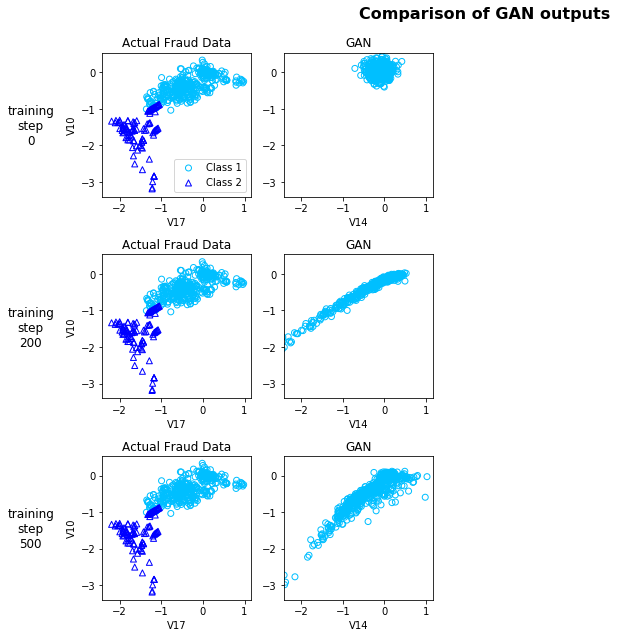

In [65]:
# Setup parameters visualization parameters
seed = 17
test_size = 492 # number of fraud cases
noise_dim = 32

np.random.seed(seed)
z = np.random.normal(size=(test_size, noise_dim))
real = synthesizer.get_data_batch(train=train_sample, batch_size=test_size, seed=seed)
real_samples = pd.DataFrame(real, columns=data_cols+label_cols)
labels = fraud_w_classes['Class']

model_names = ['GAN']
colors = ['deepskyblue','blue']
markers = ['o','^']
class_labels = ['Class 1','Class 2']

col1, col2 = 'V17', 'V10'

base_dir = 'cache/'

#Actual fraud data visualization
model_steps = [ 0, 200, 500]
rows = len(model_steps)
columns = 5

axarr = [[]]*len(model_steps)

fig = plt.figure(figsize=(14,rows*3))

for model_step_ix, model_step in enumerate(model_steps):        
    axarr[model_step_ix] = plt.subplot(rows, columns, model_step_ix*columns + 1)
    
    for group, color, marker, label in zip(real_samples.groupby('Class_1'), colors, markers, class_labels ):
        plt.scatter( group[1][[col1]], group[1][[col2]], 
                         label=label, marker=marker, edgecolors=color, facecolors='none' )
    
    plt.title('Actual Fraud Data')
    plt.ylabel(col2) # Only add y label to left plot
    plt.xlabel(col1)
    xlims, ylims = axarr[model_step_ix].get_xlim(), axarr[model_step_ix].get_ylim()
    
    if model_step_ix == 0: 
        legend = plt.legend()
        legend.get_frame().set_facecolor('white')
    
    for i, model_name in enumerate( model_names[:] ):

        [model_name, with_class, generator_model] = models[model_name]

        generator_model.load_weights( base_dir + '_generator_model_weights_step_'+str(model_step)+'.h5')

        ax = plt.subplot(rows, columns, model_step_ix*columns + 1 + (i+1) )

        if with_class:
            g_z = generator_model.predict([z, labels])
            gen_samples = pd.DataFrame(g_z, columns=data_cols+label_cols)
            for group, color, marker, label in zip( gen_samples.groupby('Class_1'), colors, markers, class_labels ):
                plt.scatter( group[1][[col1]], group[1][[col2]], 
                                 label=label, marker=marker, edgecolors=color, facecolors='none' )
        else:
            g_z = generator_model.predict(z)
            gen_samples = pd.DataFrame(g_z, columns=data_cols+['label'])
            gen_samples.to_csv('Generated_sample.csv')
            plt.scatter( gen_samples[[col1]], gen_samples[[col2]], 
                             label=class_labels[0], marker=markers[0], edgecolors=colors[0], facecolors='none' )
        plt.title(model_name)   
        plt.xlabel(data_cols[0])
        ax.set_xlim(xlims), ax.set_ylim(ylims)

plt.suptitle('Comparison of GAN outputs', size=16, fontweight='bold')
plt.tight_layout(rect=[0.075,0,1,0.95])

# Adding text labels for traning steps
vpositions = np.array([ i._position.bounds[1] for i in axarr ])
vpositions += ((vpositions[0] - vpositions[1]) * 0.35 )
for model_step_ix, model_step in enumerate( model_steps ):
    fig.text( 0.05, vpositions[model_step_ix], 'training\nstep\n'+str(model_step), ha='center', va='center', size=12)

plt.savefig('Comparison_of_GAN_outputs.png')